In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [7]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})
from matplotlib.ticker import PercentFormatter

In [49]:
pickle_in = open("../data/phosphate.pickle", "rb")
phosphate = pickle.load(pickle_in)
phosphate.drop(columns=['Hour'], inplace=True)
phosphate.describe()

,Year,Yday,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE,OXYGEN_QC_FLAG,PHOSPHATE_VALUE
count,1.263900e+04,1.263900e+04,1.263900e+04,1.263900e+04,1.263900e+04,1.263900e+04,0.0,12639.000000
mean,6.476345e-16,-3.148223e-17,1.439188e-16,-7.803096e-16,1.599297e-14,-7.735634e-16,NaN,0.396726
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,0.229053
min,-2.062907e+00,-1.743469e+00,-1.161880e+00,-3.057872e+00,-2.142688e+01,-4.709374e+00,NaN,0.020000
25%,-7.549008e-01,-8.765188e-01,-6.766341e-01,-7.243471e-01,-4.534449e-01,-7.986684e-01,NaN,0.210000
50%,7.746674e-02,2.853932e-02,-1.913882e-01,-1.109162e-01,1.160243e-01,2.130890e-01,NaN,0.330000
75%,7.909247e-01,8.764358e-01,5.364806e-01,6.434381e-01,5.946208e-01,7.383492e-01,NaN,0.570000
max,1.742202e+00,1.724332e+00,6.116808e+00,3.320981e+00,3.066360e+00,4.629456e+00,NaN,1.800000


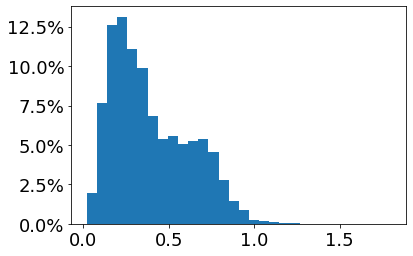

In [11]:
plt.hist(phosphate.PHOSPHATE_VALUE, bins = 30, weights = np.ones(len(phosphate.PHOSPHATE_VALUE)) / len(phosphate.PHOSPHATE_VALUE))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [50]:
pickle_in = open("../data/phosphate_wO2.pickle", "rb")
phosphate = pickle.load(pickle_in)
phosphate.drop(columns=['Hour','OXYGEN_QC_FLAG'], inplace=True)
phosphate.describe()

,Year,Yday,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE,PHOSPHATE_VALUE
count,1.263900e+04,1.263900e+04,1.263900e+04,1.263900e+04,1.263900e+04,1.263900e+04,12639.000000
mean,6.476345e-16,-3.148223e-17,1.439188e-16,-7.803096e-16,1.599297e-14,-7.735634e-16,0.396726
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.229053
min,-2.062907e+00,-1.743469e+00,-1.161880e+00,-3.057872e+00,-2.142688e+01,-4.709374e+00,0.020000
25%,-7.549008e-01,-8.765188e-01,-6.766341e-01,-7.243471e-01,-4.534449e-01,-7.986684e-01,0.210000
50%,7.746674e-02,2.853932e-02,-1.913882e-01,-1.109162e-01,1.160243e-01,2.130890e-01,0.330000
75%,7.909247e-01,8.764358e-01,5.364806e-01,6.434381e-01,5.946208e-01,7.383492e-01,0.570000
max,1.742202e+00,1.724332e+00,6.116808e+00,3.320981e+00,3.066360e+00,4.629456e+00,1.800000


In [12]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
tf.__version__

'2.2.0'

In [13]:
tf.__version__

'2.2.0'

In [35]:
len(phosphate.index)

12639

In [51]:
## Train test split
train_dataset = phosphate.sample(frac=0.80, random_state=0)
test_dataset  = phosphate.drop(train_dataset.index)

In [52]:
train_labels = train_dataset.pop('PHOSPHATE_VALUE')
test_labels = test_dataset.pop('PHOSPHATE_VALUE')

In [53]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())], kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      #layers.Dense(128, activation='tanh'),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
    ])
    
    optimizer = 'adam' #tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse', #tf.keras.losses.MAPE,#'mse',#descaled_mape(mu = train_mean, sd = train_std),
                 optimizer=optimizer,
                 metrics=[#descaled_mape(mu = train_mean, sd = train_std), 
                     'mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [54]:
model = build_model()

In [55]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


In [56]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

EPOCHS = 500

history = model.fit(
  train_dataset, train_labels, batch_size=32,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), es_callback])

loss:  0.0622, val_loss:  0.0421
..........loss:  0.0080, val_loss:  0.0075
..........loss:  0.0075, val_loss:  0.0070
..........loss:  0.0074, val_loss:  0.0071
..........loss:  0.0074, val_loss:  0.0072
..........loss:  0.0073, val_loss:  0.0071
..........loss:  0.0073, val_loss:  0.0067
..........loss:  0.0073, val_loss:  0.0068
..........loss:  0.0072, val_loss:  0.0067
..........loss:  0.0072, val_loss:  0.0068
..........loss:  0.0072, val_loss:  0.0069
..........loss:  0.0072, val_loss:  0.0067
..........loss:  0.0071, val_loss:  0.0069
..........loss:  0.0071, val_loss:  0.0067
..........loss:  0.0071, val_loss:  0.0066
..........loss:  0.0071, val_loss:  0.0066
..........loss:  0.0071, val_loss:  0.0073
..........loss:  0.0071, val_loss:  0.0067
..........loss:  0.0071, val_loss:  0.0067
..........loss:  0.0070, val_loss:  0.0066
..........loss:  0.0070, val_loss:  0.0066
..........loss:  0.0071, val_loss:  0.0066
..........loss:  0.0070, val_loss:  0.0066
..........loss:  0.00

In [42]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,16.117415,0.048976,0.006299,16.117415,18.155357,0.053685,0.006420,18.155357
std,1.747566,0.005162,0.001806,1.747566,0.498020,0.001766,0.000311,0.498020
min,14.503675,0.045539,0.005742,14.503675,17.487196,0.051181,0.005939,17.487196
25%,15.055580,0.046568,0.005904,15.055580,17.856781,0.052542,0.006211,17.856781
50%,15.727394,0.047908,0.006066,15.727394,18.017645,0.053209,0.006341,18.017645
75%,16.801097,0.049972,0.006303,16.801097,18.296114,0.054401,0.006548,18.296114
max,31.332159,0.103899,0.027902,31.332159,20.806759,0.060334,0.007552,20.806759


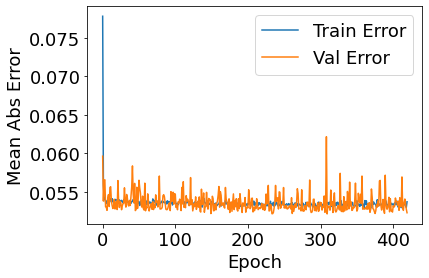

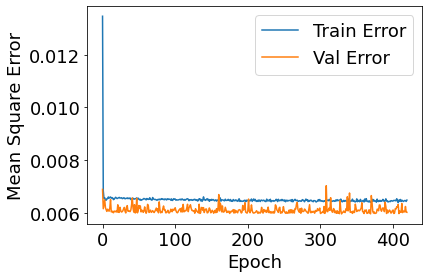

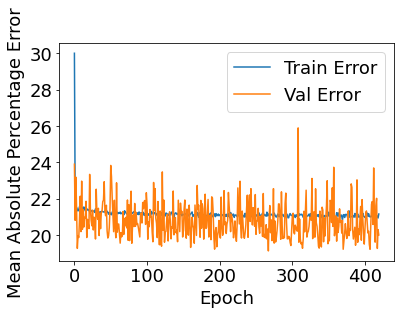

In [57]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [48]:
# without Oxygen
model.evaluate(test_dataset, test_labels)

84/84 [==============================] - 0s 1ms/step - loss: 0.0110 - mae: 0.0728 - mse: 0.0099 - mean_absolute_percentage_error: 26.1805 - root_mean_squared_error: 0.0995


[0.010990612208843231,
 0.07284311205148697,
 0.009909979067742825,
 26.18047523498535,
 0.09954887628555298]

In [58]:
# with Oxygen
model.evaluate(test_dataset, test_labels)

79/79 [==============================] - 0s 1ms/step - loss: 0.0063 - mae: 0.0523 - mse: 0.0058 - mean_absolute_percentage_error: 20.8010 - root_mean_squared_error: 0.0765


[0.006321343593299389,
 0.05226930230855942,
 0.005845275707542896,
 20.800952911376953,
 0.07645440101623535]

With Oxygen as a predictor the accuracy for both phosphate and nitrate is just slightly better, but not significantly so.

## Silicate

In [59]:
pickle_in = open("../data/silicate.pickle", "rb")
silicate = pickle.load(pickle_in)
silicate.drop(columns=['Hour'], inplace=True)
silicate.describe()

,Year,Yday,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,SILICATE_VALUE
count,8.350000e+03,8.350000e+03,8.350000e+03,8.350000e+03,8.350000e+03,8350.000000
mean,9.986742e-15,3.935641e-17,-8.722231e-17,-3.539949e-16,9.499999e-15,2.496484
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.822564
min,-1.194051e+00,-1.813677e+00,-1.205799e+00,-3.035820e+00,-1.666316e+01,0.030000
25%,-7.716737e-01,-8.617497e-01,-7.365930e-01,-7.234027e-01,-4.634432e-01,1.100000
50%,-2.437018e-01,6.073672e-02,-3.278455e-02,-1.399654e-01,9.869190e-02,2.000000
75%,2.842702e-01,8.360179e-01,5.537225e-01,5.949309e-01,5.905601e-01,3.600000
max,3.240913e+00,1.758504e+00,5.832286e+00,3.321194e+00,2.142820e+00,15.200000


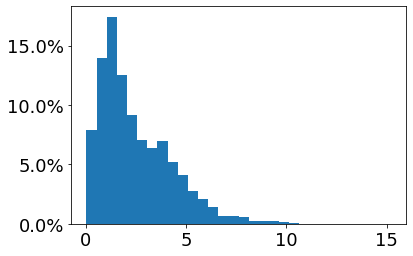

In [13]:
plt.hist(silicate.SILICATE_VALUE, bins = 30, weights = np.ones(len(silicate.SILICATE_VALUE)) / len(silicate.SILICATE_VALUE))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [72]:
pickle_in = open("../data/silicate_wO2.pickle", "rb")
silicate = pickle.load(pickle_in)
silicate.drop(columns=['Hour'], inplace=True)
silicate.describe()

,Year,Yday,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE,SILICATE_VALUE
count,6.303000e+03,6.303000e+03,6.303000e+03,6.303000e+03,6.303000e+03,6.303000e+03,6303.000000
mean,1.558392e-14,9.018470e-18,-1.803694e-17,-9.018470e-16,-1.377120e-14,1.163383e-15,2.446121
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.764782
min,-1.832594e+00,-1.812472e+00,-1.227812e+00,-3.005108e+00,-1.646786e+01,-4.407034e+00,0.100000
25%,-9.173679e-01,-8.661374e-01,-6.684146e-01,-7.107048e-01,-4.835897e-01,-8.432121e-01,1.100000
50%,-2.141772e-03,5.062386e-02,-1.090168e-01,-1.284785e-01,1.112326e-01,1.048204e-01,1.900000
75%,6.842779e-01,8.392357e-01,3.385014e-01,6.090081e-01,6.048086e-01,7.872002e-01,3.500000
max,2.057117e+00,1.775712e+00,5.484961e+00,3.420946e+00,2.161471e+00,4.692212e+00,11.100000


In [73]:
## Train test split
train_dataset = silicate.sample(frac=0.80, random_state=0)
test_dataset  = silicate.drop(train_dataset.index)

In [74]:
train_labels = train_dataset.pop('SILICATE_VALUE')
test_labels = test_dataset.pop('SILICATE_VALUE')

In [68]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dense(32, activation='relu'),
      #layers.Dense(128, activation='tanh'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = 'adam' #tf.keras.optimizers.RMSprop()
    
    model.compile(loss=tf.keras.losses.MAPE,#'mse',#descaled_mape(mu = train_mean, sd = train_std),
                 optimizer=optimizer,
                 metrics=[#descaled_mape(mu = train_mean, sd = train_std), 
                     'mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [75]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())], kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      #layers.Dense(128, activation='tanh'),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
    ])
    
    optimizer = 'adam' #tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse', #tf.keras.losses.MAPE,#'mse',#descaled_mape(mu = train_mean, sd = train_std),
                 optimizer=optimizer,
                 metrics=[#descaled_mape(mu = train_mean, sd = train_std), 
                     'mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [76]:
model = build_model()

In [77]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 9         
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


In [78]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

EPOCHS = 500

history = model.fit(
  train_dataset, train_labels, batch_size=64,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

loss:  5.7503, val_loss:  2.0063
..........loss:  1.0842, val_loss:  1.0559
..........loss:  0.8425, val_loss:  0.8862
..........loss:  0.7367, val_loss:  0.7708
..........loss:  0.6369, val_loss:  0.6631
..........loss:  0.5767, val_loss:  0.6045
..........loss:  0.7926, val_loss:  0.5706
..........loss:  0.5570, val_loss:  0.5423
..........loss:  0.4852, val_loss:  0.4990
..........loss:  0.4722, val_loss:  0.5149
..........loss:  0.4537, val_loss:  0.4676
..........loss:  0.4352, val_loss:  0.4680
..........loss:  0.4512, val_loss:  0.4481
..........loss:  0.4177, val_loss:  0.4416
..........loss:  0.4321, val_loss:  0.4423
..........loss:  0.3956, val_loss:  0.4499
..........loss:  0.3953, val_loss:  0.4153
..........loss:  0.3904, val_loss:  0.4140
..........loss:  0.3828, val_loss:  0.4085
..........loss:  0.3829, val_loss:  0.4508
..........loss:  0.3840, val_loss:  0.4221
..........loss:  0.6122, val_loss:  0.4793
..........loss:  0.3686, val_loss:  0.4099
..........loss:  0.39

In [72]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,25.890192,0.595248,1.224318,25.890192,28.857680,0.587094,1.160346,28.857680
std,4.134597,0.084371,0.280936,4.134597,1.709673,0.035259,0.088894,1.709673
min,22.299702,0.533934,1.060825,22.299702,27.198786,0.547196,1.035296,27.198786
25%,23.663561,0.558111,1.126935,23.663561,28.169201,0.563607,1.098722,28.169201
50%,25.082790,0.581736,1.190337,25.082790,28.568977,0.585860,1.152109,28.568977
75%,26.931696,0.612997,1.270946,26.931696,28.932478,0.598284,1.199732,28.932478
max,63.130394,1.483936,4.434511,63.130394,41.998142,0.860397,1.794028,41.998142


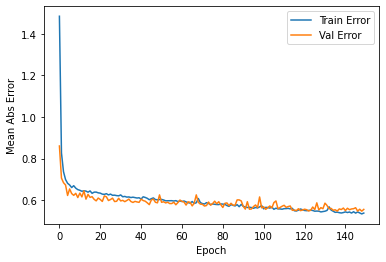

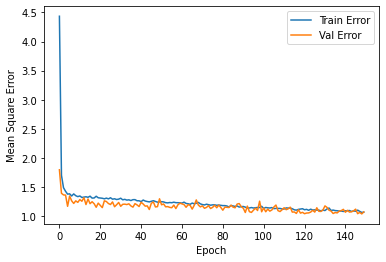

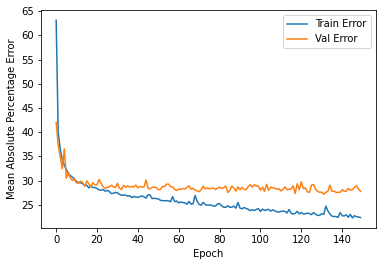

In [73]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

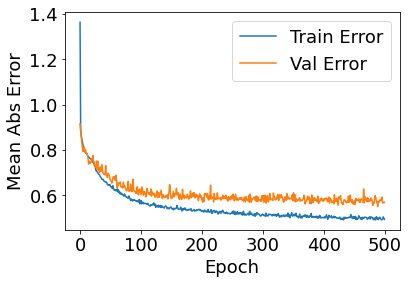

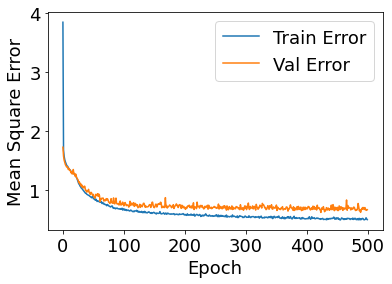

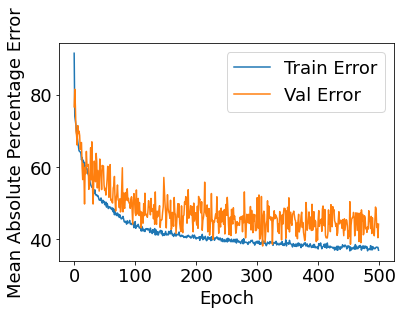

In [70]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

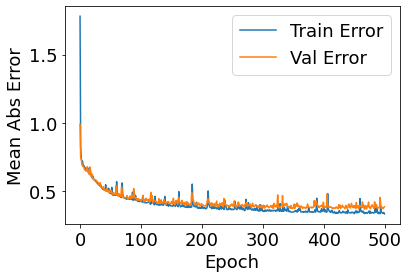

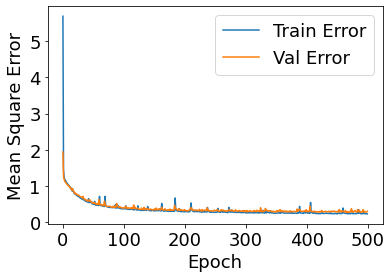

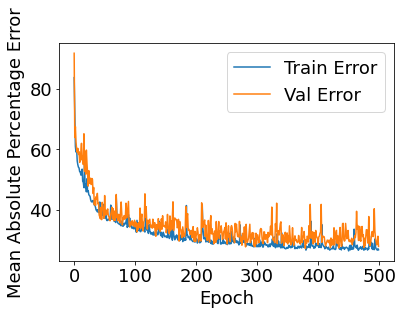

In [79]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [71]:
#without O2
model.evaluate(test_dataset, test_labels)

53/53 [==============================] - 0s 1ms/step - loss: 0.8769 - mae: 0.5507 - mse: 0.7835 - mean_absolute_percentage_error: 38.9670 - root_mean_squared_error: 0.8851


[0.8769070506095886,
 0.5506531596183777,
 0.7834679484367371,
 38.96699523925781,
 0.8851372599601746]

In [80]:
#with O2
model.evaluate(test_dataset, test_labels)

40/40 [==============================] - 0s 1ms/step - loss: 0.4887 - mae: 0.4327 - mse: 0.4162 - mean_absolute_percentage_error: 26.9549 - root_mean_squared_error: 0.6451


[0.48874011635780334,
 0.4326510727405548,
 0.41617530584335327,
 26.954875946044922,
 0.6451165080070496]